# Imports and Installs

In [1]:
#Installs & Imports
!pip install scipy
!pip install matplotlib
!pip install numpy
!pip install torchvision
import gym 
import math
from gym import spaces
import collections
import pprint
import torch
import numpy as np
import random
import operator
import matplotlib.pyplot as plt
import copy

#MDP

In [37]:
#constants
GAMMA = 0.9
TEST_EPISODES = 20
REWARD_GOAL = 0.8
N = 1000

class MDP:
    def init(self):
        self.S = [0, 1, 2]
        self.endstate = self.S[-1]
        self.gamma = 0.99 #for val_iteration_for_q
        self.actions = [0, 1, 2] # 0 = BACK, 1 = FORWARD, 2 = STAY
        self.currentstate = self.S[0]
        self.rewards = {0: -1, 1: 0.5, 2: 1.5} #true optimal reward function
        self.T = {
            (0, 0): {0: 0.7, 1: 0.2, 2: 0.1},  
            (0, 1): {0: 0.1, 1: 0.7, 2: 0.2}, 
            (0, 2): {0: 0.7, 1: 0.2, 2: 0.1}, 
            (1, 0): {0: 0.7, 1: 0.2, 2: 0.1}, 
            (1, 1): {0: 0.1, 1: 0.2, 2: 0.7}, 
            (1, 2): {0: 0.1, 1: 0.7, 2: 0.2},
            (2, 0): {0: 0.2, 1: 0.7, 2: 0.1}, 
            (2, 1): {0: 0.7, 1: 0.2, 2: 0.1},
            (2, 2): {0: 0.1, 1: 0.2, 2: 0.7}}
        self.Q = collections.defaultdict(float)
        self.V = collections.defaultdict(float)
      
        
    #helper functions
    def normalise_Q(self):
        #normalises self.Q
        current_values = list(self.Q.values())
        normalized_values = NormalizeData(current_values)
        i = 0
        for state in self.S: #for each state
            for action in self.actions: #for each action
                self.Q[(state, action)] = normalized_values[i]
                i += 1

    def step(self, state, action):
        outcomes = self.T[state,action].values() #get T(s'|s,a)
        probs = [] #empty list
        for item in outcomes:
            probs.append(item) #populate probs list with outcomes 
        probs = np.array(probs) #cast probs list to np.array
        newstatearray = np.random.multinomial(1, probs).tolist() #get new state array e.g [0,1,0]
        new_state = newstatearray.index(1) #get actual state
        return new_state
       
    def select_action(self, state):
        best_action, best_value = None, None #initialise
        for action in range(len(self.actions)): #for each action
            action_value = self.Q[(state, action)] #get utility
            if best_value is None or best_value < action_value: #if action value > best value 
                best_value = action_value #set the value as best value
                best_action = action #set the action as best action
        return best_action #return action from state which yields highest utility 

    def get_state_utility(self, state):
        utility = 0
        for action in self.actions:
            utility += math.exp(self.Q[state, action])#sum utilities of all possible actions from given state

        return math.log(utility) #return log of Q of all action in  state 

    #functions
    def value_iteration_for_Q(self):
        for state in self.S:
            self.V[state] = 0
        i = 1
        converged = False
        while not converged:
            Vp = copy.copy(self.V)
            for state in self.S: 
                for action in self.actions: 
                    #Q(s,a) = r(s) + GAMMA * sum(T(s' a | s) * Vp(s'))
                    q = self.rewards[state]
                    target_probs = self.T[state,action]
                    sumT = 0
                    for tgt_state, probability in target_probs.items():             
                        sumT += probability * Vp[tgt_state] #sum(T(s' a | s) * Vp(s')

                    q += GAMMA * sumT #r(s) + GAMMA * sum(T(s' a | s) * Vp(s'))
                    self.Q[state, action] = q #Q(s,a)

            for state in self.S:
                #Soft Maxent: V(s) = maxQ(s,a) + log(sum(exp(Q(s,a) - maxQ(s,a))))
                best_action = self.select_action(state) 
                maxQ = self.Q[(state, best_action)] #maxQ(s,a)
                tempV = 0
                for action in self.actions: #sum()
                    tempV += math.exp(self.Q[state, action] - maxQ) #exp(Q(s,a) - maxQ(s,a)
                self.V[state] = maxQ + math.log(tempV) #update V(s)
                        
            diff = []
            for state in self.S:
                #check if diff between V and vp V  is within convergence critera
                diff.append(abs(self.V[state] - Vp[state]))
            diffMax = max(diff)

            """
            formatlist = [i, diffMax]
            print("Absoloute difference between V(s) & Vp on iteration {} is {}".format(*formatlist))
            i += 1
            """
            
            if diffMax < 0.000001:
                converged = True

    def find_optimal_policy(self):
        policy = [None] * len(self.S) #initialise empty policy
        for state in self.S: #for each state
            best_action = self.select_action(state) #select action with highest utility
            policy[state] = best_action #set this as optimal action
        return policy

    def sample_paths(self, policy, no_paths):
        paths = []
        path = []
        self.currentstate = self.S[0]
        while (len(paths) != no_paths):

            outcomes = self.T[self.currentstate, policy[self.currentstate]].values() #get probability of target states given action from policy as dict value obj
            probs = [] #empty list
            for item in outcomes:
                probs.append(item) #populate probs list with outcomes 
            probs = np.array(probs) #cast probs list to np.array
            newstatearray = np.random.multinomial(1, probs).tolist() #get new state array e.g [0,1,0]
            new_state = newstatearray.index(1) #get actual state
    
            path.append(policy[new_state]) #add action to path
            endstate = self.endstate
            if (new_state == endstate): #if at terminal state
                #if (path not in paths and path != [1,1,2]): 
                paths.append(path) #add path to paths
                path = [] #reset path
                self.currentstate = self.S[0] #reset to start state

            else:
                self.currentstate = new_state 

        return paths

    def sample_examples(self, policy, no_paths, path_length):
        paths =  [None] * no_paths
        for i in range(no_paths):
            s = self.S[0]
            path = [None] * path_length
            path[0] = (s,policy[s]) #intial state and action
            for t in range(1, path_length):
                new_state = self.step(s, policy[s]) #get new state from optimal action
                #store action and new_state in path
                path[t] = (new_state,policy[s])
                #take action and set new state
                s = new_state
            paths[i] = path

        return paths

In [3]:
#global helper functions
def NormalizeData(data):
    #normalises data to be within 0-1
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def Normalize_rewards_to_1(data):
    sum_val = sum(data)
    for item in data:
        index = data.index(item) #get index 
        new_item = item / sum_val
        data[index] = new_item
    return data

#Likelihood & Hillclimb Function

In [14]:
def likelihood(paths, rewards):
    new_values = Normalize_rewards_to_1(list(rewards.values()))
    for i in range(len(rewards)):
        rewards[i] = new_values[i]
    agent = MDP()
    agent.init()
    agent.rewards = rewards
    agent.value_iteration_for_Q()
    agent.find_optimal_policy()
    likelihoodList = [] 
    for path in paths:
        actionLikelihoodList = [None] * len(path) #empty list length of path
        i = 0
        for step in path:
            state = step[0]
            action = step[1] 
            #state = max(agent.T[(state, action)].items(), key=operator.itemgetter(1))[0]
            #new_state = agent.step(state,action)
            actionLikelihoodList[i] = agent.Q[(state,action)]  - agent.V[state]#Q^Rstate,action −V^Rstate
            i += 1
        likelihoodList.append(sum(actionLikelihoodList))
    return sum(likelihoodList)/len(likelihoodList)*100 

In [45]:
def stochastic_hillclimb(paths, threshold):
    Start = -1 #lower reward limit
    Stop = 1 #upper reward limit
    limit = 3 #number of states we are estimating rewards for 
    likelihood_threshold = threshold
    threshold_reached = False 
    final_rewards = collections.defaultdict(float) #reward dict to be returned
    dict_rewards = collections.defaultdict(float) #for inital likelihood calc
    sigma = 0.3 #set standard deviation
    sampledRewards = [random.uniform(Start, Stop) for iter in range(limit)] #initial random list of rewards

    while(sum(sampledRewards) <= 0.0):
        sampledRewards = [random.uniform(Start, Stop) for iter in range(limit)] #ensure random list of rewards are non-zero

    sampledRewards = Normalize_rewards_to_1(sampledRewards) #ensure rewards sum to 1
    dict_rewards = {0: sampledRewards[0], 1: sampledRewards[1], 2: sampledRewards[2]}
    previousLikelihood = likelihood(paths, dict_rewards)

    rewards_list_for_plotting = []
    iterations = []
    i = 1

    while not threshold_reached:

        #sample each states reward
        state0Reward = random.normalvariate(sampledRewards[0], sigma) 
        state1Reward = random.normalvariate(sampledRewards[1], sigma) 
        state2Reward = random.normalvariate(sampledRewards[2], sigma)

        #normalise rewards so they sums to one
        normalised_rewards = Normalize_rewards_to_1([state0Reward, state1Reward, state2Reward])

        rewards = {0: normalised_rewards[0], 1: normalised_rewards[1], 2: normalised_rewards[2]} #map to dictionary {state:rewards}
        rewards_likelihood = likelihood(paths, rewards) #get likelihood of current reward function
        
        
        """
        formatlist = [rewards, rewards_likelihood]
        print("Rewards: {},   likeihood: {}".format(*formatlist))
        """


        #gather metrics for plotting
        rewards_list_for_plotting.append(rewards_likelihood)
        iterations.append(i)
        i+=1

        diff = [abs(-1-normalised_rewards[0]), abs(0.5-normalised_rewards[1]), abs(1.5-normalised_rewards[2])]
        print("True R - Est R = {}".format(diff))

        if rewards_likelihood > likelihood_threshold: #once threshold met
            #terminate and return
            threshold_reached = True
            final_rewards = rewards

    rewards_list_for_plotting = (rewards_list_for_plotting-np.mean(rewards_list_for_plotting))/np.std(rewards_list_for_plotting)
    plt.scatter(iterations,rewards_list_for_plotting)
    plt.plot(iterations,rewards_list_for_plotting)
    plt.xlabel('Iterations')
    plt.ylabel('Likelihood')
    #plt.axhline(y=likelihood_threshold, color='r', linestyle=':')


    return final_rewards

#Main

In [38]:
#Initialising MDP
agent = MDP()
agent.init()
agent.value_iteration_for_Q()
optimal_policy = agent.find_optimal_policy()

In [39]:
#Sample paths
no_of_paths = 5000
path_length = 5
paths = agent.sample_examples(optimal_policy, no_of_paths, path_length)

In [47]:
printlist = [agent.rewards, likelihood(paths, agent.rewards), optimal_policy]
priorrewards = agent.rewards
print("\nThe true reward function {}\nhas likelihood of {} and optimal policy {}".format(*printlist))

formatlist = [no_of_paths, paths]
print("\nThe {} sampled paths, in format [(s0,a0) ... (sn,an)] are: {}".format(*formatlist))

print("\nThe Q under optimal reward func is: \n")
pprint.pprint(agent.Q)


The true reward function {0: -1.0, 1: 0.5, 2: 1.5}
has likelihood of -477.89076264965587 and optimal policy [1, 1, 2]

The 5000 sampled paths, in format [(s0,a0) ... (sn,an)] are: [[(0, 1), (1, 1), (1, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (0, 1), (0, 1), (1, 1)], [(0, 1), (1, 1), (0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (2, 1), (2, 2), (0, 2)], [(0, 1), (2, 1), (2, 2), (2, 2), (1, 2)], [(0, 1), (1, 1), (0, 1), (2, 1), (2, 2)], [(0, 1), (2, 1), (0, 2), (1, 1), (1, 1)], [(0, 1), (1, 1), (2, 1), (2, 2), (2, 2)], [(0, 1), (2, 1), (2, 2), (2, 2), (2, 2)], [(0, 1), (1, 1), (2, 1), (0, 2), (1, 1)], [(0, 1), (2, 1), (0, 2), (1, 1), (2, 1)], [(0, 1), (1, 1), (2, 1), (2, 2), (2, 2)], [(0, 1), (1, 1), (1, 1), (2, 1), (2, 2)], [(0, 1), (2, 1), (0, 2), (1, 1), (0, 1)], [(0, 1), (1, 1), (2, 1), (2, 2), (2, 2)], [(0, 1), (1, 1), (0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (2, 1), (2, 2), (1, 2)], [(0, 1), (1, 1), (1, 1), (2, 1), (2, 2)], [(0, 1), (1, 1), (0, 1), (2, 1), (0, 2)], [(0, 1), (2, 1), (2,

True R - Est R = [1.5135704905911784, 0.17296876059196437, 1.3406017299992141]
True R - Est R = [1.270912718412895, 0.12585084917515366, 1.3967635675880488]
True R - Est R = [1.3528439633456122, 0.05963869652563042, 1.2932052668199818]
True R - Est R = [1.36640095405445, 0.06079495889623354, 1.3056059951582166]
True R - Est R = [1.3456058782983251, 0.0625114435472901, 1.4081173218456153]
True R - Est R = [1.8544993723953125, 0.1440746902691118, 1.9985740626644244]
True R - Est R = [1.7137308019774973, 0.04598361564903375, 1.6677471863284634]
True R - Est R = [1.8854258029662005, 0.6510772281687219, 1.2343485747974787]
True R - Est R = [1.370523961385688, 0.1154450261724752, 1.255078935213213]
True R - Est R = [1.8561805380612266, 0.2701262108126263, 1.5860543272486003]
True R - Est R = [1.4672826560083054, 0.3561800748326208, 1.1111025811756845]
True R - Est R = [1.1298759256426905, 0.6864663731557972, 0.4434095524868933]
True R - Est R = [1.3408357172401746, 0.16592282561442095, 1.506

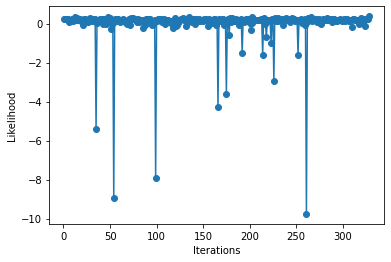

In [46]:
optimal_rewards = stochastic_hillclimb(paths, -477.89)
agent.rewards = optimal_rewards
agent.value_iteration_for_Q()
formatlist = [optimal_rewards, likelihood(paths, optimal_rewards), agent.find_optimal_policy()]
print("\nHill climb converges at reward function {}\nwith a likelihood of {} and optimal policy {}".format(*formatlist))
print("\nThe Q under found reward func is: \n")
pprint.pprint(agent.Q)
agent.rewards = priorrewards

#Testing Reward Func

In [19]:
#edit to test diff reward functions    
agent = MDP()
agent.init()
agent.value_iteration_for_Q()
testing_rewardfunc = {0: -0.9, 1: 0.6, 2: 1.5}
testing_rewardfunc1 = {0: -1, 1: 0.9, 2: 1.1}
LH = likelihood(paths, agent.rewards) #agent.rewards = {0: -1, 1: 0.5, 2: 1.5}
LH1 = likelihood(paths, testing_rewardfunc)
LH2 = likelihood(paths, testing_rewardfunc1)
print("Likelihood of true reward func is {}".format(LH))
print("\n\nLikelihood of test reward func is {}".format(LH1))
print("\n\nLikelihood of 2nd test reward func is {}".format(LH2))

Likelihood of true reward func is -379.94552165014017


Likelihood of test reward func is -381.385065381661


Likelihood of 2nd test reward func is -391.41874683111115


# **ignore** *Copy Paste Dump* 

In [ ]:
"""
threshold = 0.0001
action = 0
TEST_EPISODES = 20
REWARD_GOAL = 0.8
N =100

        #hard coded R
        self.R_hardcoded = {(0, 0, 0): 0.0, 
                  (0, 0, 1): 0.0, 
                  (0, 0, 2): 1.0,
                  (0, 1, 0): 0.0,
                  (0, 1, 1): 0.0, 
                  (0, 1, 2): 1.0,
                  (0, 2, 0): 0.0,
                  (0, 2, 1): 0.0,
                  (1, 0, 0): 0.0, 
                  (1, 0, 1): 0.0, 
                  (1, 0, 2): 1.0,
                  (1, 1, 0): 0.0,
                  (1, 1, 1): 0.0, 
                  (1, 1, 2): 1.0,
                  (1, 2, 0): 0.0,
                  (1, 2, 1): 0.0,
                  (1, 2, 2): 1.0,
                  (2, 0, 0): 0.0, 
                  (2, 0, 1): 0.0, 
                  (2, 0, 2): 1.0,
                  (2, 1, 0): 0.0,
                  (2, 1, 1): 0.0, 
                  (2, 1, 2): 1.0,
                  (2, 2, 0): 0.0,
                  (2, 2, 1): 0.0,
                  (2, 2, 2): 1.0}

        #hard coded T

def step(self, action):
        isdone = False
        if action == 2:
            currentstate = self.currentstate #remain at current state
        elif action == 1:
            try:
                currentstate = self.actions[self.actions.index(self.currentstate)+1] #take step to right
            except IndexError:
                currentstate = self.actions[0]
        else:
            try:
                currentstate = self.actions[self.actions.index(self.currentstate)-1] #take step to left
            except IndexError:
                currentstate = self.currentstate
        if currentstate == self.endstate:
            isdone = True
        else:
            isdone = False

        return currentstate, self.rewards[currentstate], isdone
        
        
        #single path function
        def likelihood1(policy, agent):
            likelihoodList = [None] * len(policy)
            for i in range(len(policy)):
                state = int(i)
                action = int(policy[i])    
                likelihoodList[i] = agent.values[state,action]  - agent.get_state_utility(state) 
            return sum(likelihoodList) / len(likelihoodList)

            #create random policies for testing
actions = [0, 1, 2, 3]
nonoptimal1 = [None] * 16
nonoptimal2 = [None] * 16
nonoptimal3 = [None] * 16
policies = [nonoptimal1, nonoptimal2, nonoptimal3]
for policy in policies:
    for i in range(len(policy)):
        policy[i] = random.choice(actions)

#create random reward functions for testing
nonoptimal_rewardfunc1 = np.random.rand(env.observation_space.n,env.action_space.n)
nonoptimal_rewardfunc2 = np.random.rand(env.observation_space.n,env.action_space.n)
nonoptimal_rewardfunc3 = np.random.rand(env.observation_space.n,env.action_space.n)


#get optimal reward function
q_table = create_q_table(env) 


print("---------------------------------------")
print("\n*** Testing likelihood function using optimal policy with random reward functions ***\n")
print("---------------------------------------")
print("\n")
print("Likelihood for optimal reward function is {}".format(likelihood(optimal_policy, q_table)))
print("Likelihood for non optimal reward function 1 is {}".format(likelihood(optimal_policy, nonoptimal_rewardfunc1)))
print("Likelihood for non optimal reward function 2 is {}".format(likelihood(optimal_policy, nonoptimal_rewardfunc2)))
print("Likelihood for non optimal reward function 3 is {}".format(likelihood(optimal_policy, nonoptimal_rewardfunc3)))
print("\n")


print("---------------------------------------")
print("\n*** Testing likelihood function using optimal reward function with random policies ***\n")
print("---------------------------------------")
print("\n")
print("Likelihood for optimal policy  is {}".format(likelihood(optimal_policy, q_table)))
print("Likelihood for non optimal policy 1 is {}".format(likelihood(nonoptimal1, q_table)))
print("Likelihood for non optimal policy 2 is {}".format(likelihood(nonoptimal2, q_table)))
print("Likelihood for non optimal policy 3 is {}".format(likelihood(nonoptimal3, q_table)))
print("\n")
                
"""

def likelihood2(paths, agent):
    likelihoodList = []
    for path in paths:
        actionLikelihoodList = [None] * len(path)
        for i in range(len(path)):
            state = int(i)
            action = int(path[i])    
            actionLikelihoodList[i] = agent.values[state,action]  - agent.get_state_utility(state) 
        likelihoodList.append(sum(actionLikelihoodList) / len(actionLikelihoodList))
    return likelihoodList

"""
likelihoods = likelihood(paths, agent) #function call

#formatting output
print("The paths are: {}".format(paths))
for l in likelihoods:
    index = likelihoods.index(l)
    value = likelihoods[index]
    formatlist = [index+1, value]
    print("\nLikelihood for path {} is {}".format(*formatlist))

print("\nThe optimal policy is path {}".format(likelihoods.index(max(likelihoods))+1))

#take R as input and compute values in function
"""

def likelihood2(paths, rewards):
    listoflikelihoodlists = []
    for reward in rewards:
        agent = MDP()
        agent.init()
        agent.rewards = reward
        agent.play_n_random_steps(N)
        agent.value_iteration_for_Q()
        agent.find_optimal_policy()
        likelihoodList = []
        for path in paths:
            actionLikelihoodList = [None] * len(path)
            for i in range(len(path)):
                state = int(i)
                action = int(path[i])    
                actionLikelihoodList[i] = agent.values[state,action]  - agent.get_state_utility(state) 
            likelihoodList.append(sum(actionLikelihoodList) / len(actionLikelihoodList))
        listoflikelihoodlists.append(likelihoodList)
    
    
    return listoflikelihoodlists
"""
#0: 0.0, 1: 0.2, 2: 1.0
likelihoods = likelihood(paths, {0: 0.0, 1: 0.2, 2: 1.0}) #function call
formatlist = [paths, {0: 0.0, 1: 0.2, 2: 1.0}, likelihoods]
print("The likelihoods of paths: \n{}\nunder the rewards: \n{}\nare: \n\n{}\n\n".format(*formatlist))

#0: 0.0, 1: 0.0, 2: 1.0
likelihoods = likelihood(paths, {0: 0.0, 1: 0.0, 2: 1.0}) #function call
formatlist = [paths, {0: 0.0, 1: 0.0, 2: 1.0}, likelihoods]
print("The likelihoods of paths: \n{}\nunder the rewards: \n{}\nare: \n\n{}\n\n".format(*formatlist))

#0: 0.0, 1: 0.8, 2: 1.0
likelihoods = likelihood(paths, {0: 0.0, 1: 0.8, 2: 1.0}) #function call
formatlist = [paths, {0: 0.0, 1: 0.8, 2: 1.0}, likelihoods]
print("The likelihoods of paths: \n{}\nunder the rewards: \n{}\nare: \n\n{}\n\n".format(*formatlist))




rewards = [{0: 0.0, 1: 0.2, 2: 1.0},
{0: 0.0, 1: 0.0, 2: 1.0},
{0: 0.0, 1: 0.8, 2: 1.0},
{0: 0.0, 1: 1.0, 2: 2.0}]


listoflikelihoodlists = likelihood1(paths, rewards)

print("\n\n\nSum of likelihoods for each reward func are:")

for list in listoflikelihoodlists:
    print(sum(list))
"""

'''
def play_n_random_steps(self, count):
        for _ in range(count):
            action = random.choice(self.actions) #select random action
            new_state, reward, is_done = self.step(action) #take random action
            self.R[(self.currentstate, action, new_state)] = reward #populate R with findings 
            self.currentstate = new_state #increment state
        self.currentstate = self.S[0] #reset starting state
'''
